# Week 2: Implementing Callbacks in TensorFlow using the MNIST Dataset

In the lectures you learned how to do classification using Fashion MNIST, a dataset containing items of clothing. There's another, similar dataset called MNIST which has items of handwriting -- the digits 0 through 9.

In this assignment you will code a classifier for the MNIST dataset, that trains until it reaches 98% accuracy and stops once this threshold is achieved. In the lectures you saw how this was done for the loss but here you will be using accuracy instead.

Some notes:
1. Your network should succeed in less than 10 epochs.
2. When it reaches 98% or greater it should print out the string "Reached 98% accuracy so cancelling training!" and stop training.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

In [29]:
import os
import base64
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
import unittests

ModuleNotFoundError: No module named 'unittests'

## Load and inspect the data

Begin by loading the data. A couple of things to notice:

- The file `mnist.npz` is already included in the current workspace under the `data` directory. By default the `load_data` from Keras accepts a path relative to `~/.keras/datasets` but in this case it is stored somewhere else, as a result of this, you need to specify the full path.

- `tf.keras.datasets.mnist.load_data` returns the train and test sets in the form of the tuples `(training_images, training_labels), (testing_images, testing_labels)` but in this exercise you will be needing only the train set so you can ignore the second tuple.

In [6]:
# Get current working directory
current_dir = os.getcwd()

# Append data/mnist.npz to the previous path to get the full path
data_path = os.path.join(current_dir, "mnist.npz")

# Load data (discard test set)
(training_images, training_labels), _ = tf.keras.datasets.mnist.load_data(path=data_path)

print(f"training_images is of type {type(training_images)}.\ntraining_labels is of type {type(training_labels)}\n")

# Inspect shape of the data
data_shape = training_images.shape

print(f"There are {data_shape[0]} examples with shape ({data_shape[1]}, {data_shape[2]})")

training_images is of type <class 'numpy.ndarray'>.
training_labels is of type <class 'numpy.ndarray'>

There are 60000 examples with shape (28, 28)


Text(0.5, 1.0, 'Label: 6')

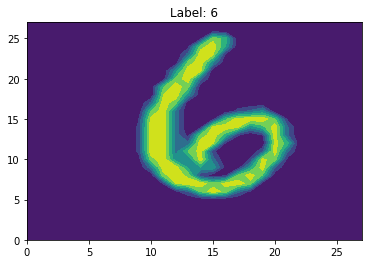

In [25]:
idx=2300
plt.contourf(training_images[idx, ::-1,:])
plt.title(f"Label: {training_labels[idx]}")

One important step is to normalize the pixel values. The dataset includes black and white images and the pixel values for these kinds of images usually range from 0 to 255 but the network will have an easier time learning if these values range from 0 to 1.

The data comes as numpy arrays so you can easily normalize the pixel values by using vectorization:

In [7]:
# Normalize pixel values
training_images = training_images / 255.0

## Exercise 1: create_and_compile_model

Your first task is to create and compile the model that you will later train to recognize handwritten digits.

Feel free to try the architecture for the neural network that you see fit but in case you need extra help you can check out an architecture that works pretty well at the end of this notebook. Notice that the part where the model is compiled is already provided (and the `accuracy` metric is defined so it can be accessed by your callback later on) so you only need to specify the layers of the model.

Hints:
- The first layer should take into consideration the `input_shape` of the data, which in this case is the size of each image
- The last layer should take into account the number of classes you are trying to predict

In [45]:
# GRADED FUNCTION: create_and_compile_model

def create_and_compile_model():
    """Returns the compiled (but untrained) model.

    Returns:
        tf.keras.Model: The model that will be trained to predict predict handwriting digits.
    """

    ### START CODE HERE ###

    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    ### END CODE HERE ###

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [37]:
# Save untrained model in a variable
untrained_model = create_and_compile_model()

# Check parameter count against a reference solution
# unittests.parameter_count(untrained_model)

In [38]:
# Use it to predict the first 5 images in the train set
predictions = untrained_model.predict(training_images[:5], verbose=False)

print(f"predictions have shape: {predictions.shape}")

predictions have shape: (5, 10)


**Expected Output:**

```
predictions have shape: (5, 10)
```

In [ ]:
# Test your code!
unittests.test_create_and_compile_model(create_and_compile_model)

## Exercise 2: EarlyStoppingCallback

Now it is time to create your own custom callback. For this complete the `EarlyStoppingCallback` class and the `on_epoch_end` method in the cell below. If you need some guidance on how to proceed, check out this [link](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks).

In [40]:
# GRADED CLASS: EarlyStoppingCallback

### START CODE HERE ###

# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.98):
        super(EarlyStoppingCallback, self).__init__()
        self.accuracy = accuracy

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs={}):
        # Check if the accuracy is greater or equal to the specified accuracy
        if logs.get('accuracy') >= self.accuracy:
            # Stop training once the above condition is met
            self.model.stop_training = True

            print(f"\nReached {self.accuracy*100}% accuracy so cancelling training!")

### END CODE HERE ###

In [ ]:
# Test your code!
# unittests.test_EarlyStoppingCallback(EarlyStoppingCallback)

## Exercise 3: train_mnist

Now that you have defined your callback it is time to complete the `train_mnist` function below. This function will receive the training data (features and targets encoded as numpy arrays) and should use it to train the model you defined earlier. It should also return the training history of the model. This object is returned when using the `fit` method of a `tf.keras.Model` as explained in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

**You must set your model to train for 10 epochs and the callback should fire before the 10th epoch for you to pass this part of the assignment**

In [46]:
# GRADED FUNCTION: train_mnist

def train_mnist(training_images, training_labels):
    """Trains a classifier of handwritten digits.

    Args:
        training_images (numpy.ndarray): The images of handwritten digits
        training_labels (numpy.ndarray): The labels of each image

    Returns:
        tf.keras.callbacks.History : The training history.
    """

    ### START CODE HERE ###

    # Create a compiled (but untrained) version of the model
    # Hint: Remember you already coded a function that does this!
    model = create_and_compile_model()

    
    # Fit the model for 10 epochs adding the callbacks and save the training history
    history = model.fit(training_images, training_labels, epochs=10,
                        callbacks=[EarlyStoppingCallback()])

    ### END CODE HERE ###

    return history

Now train the model and get the training history by calling the `train_mnist` function, passing in the appropiate parameters:

In [47]:
training_history = train_mnist(training_images, training_labels)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9019 - loss: 0.3327
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9736 - loss: 0.0821
Epoch 3/10
1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0512
Reached 98% accuracy so cancelling training!
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9842 - loss: 0.0512


**Expected Output:**

`Reached 98% accuracy so cancelling training!` printed out before reaching 10 epochs.


In [ ]:
# Test your code!
unittests.test_training_history(training_history)

## Need more help?

Run the following cell to see an architecture that works well for the problem at hand:

In [39]:
# WE STRONGLY RECOMMEND YOU TO TRY YOUR OWN ARCHITECTURES FIRST
# AND ONLY RUN THIS CELL IF YOU WISH TO SEE AN ANSWER

encoded_answer = "CiAgIC0gQSB0Zi5rZXJhcy5JbnB1dCB3aXRoIHRoZSBzYW1lIHNoYXBlIGFzIHRoZSBpbWFnZXMKICAgLSBBIEZsYXR0ZW4gbGF5ZXIKICAgLSBBIERlbnNlIGxheWVyIHdpdGggNTEyIHVuaXRzIGFuZCBSZUxVIGFjdGl2YXRpb24gZnVuY3Rpb24KICAgLSBBIERlbnNlIGxheWVyIHdpdGggMTAgdW5pdHMgYW5kIHNvZnRtYXggYWN0aXZhdGlvbiBmdW5jdGlvbgo=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


   - A tf.keras.Input with the same shape as the images
   - A Flatten layer
   - A Dense layer with 512 units and ReLU activation function
   - A Dense layer with 10 units and softmax activation function



**Congratulations on finishing this week's assignment!**

You have successfully implemented a callback that gives you more control over the training loop for your model. Nice job!

**Keep it up!**